# Outline

# Quick introduction to T-SNE

## Overview
Since we didn't cover t-sne in lecture I wanted to give a very brief introduction. This will be non-technical and just introduces a basic conceptual picture.

T-sne maps highe dimensional data to a lower dimensions for clustering and/or visualiaztion. The algorithm works by attempting to preserve pair-wise distances between points in the original space. In other words, points that are close together in feature space are also close together on the feature map. Since it is not possible to preserve all distances while reducing distances, the distance between points that are close to each other are prioritized over distances between points that are far away from each other. This preserves clusters, but does not preserve the relative positions of clusters. Specifically, t-SNE minimizes KL divergence, which is a statistical distance function with a similar form to entropy. t-SNE maps with lower KL divergence preserve the structure of the original data better than maps with higher KL divergence.

The S in T-sne stands for stochastic, so the same points will result in significantly different t-sne maps, even with the same settings. In most cases you may want to run t-sne multiple times and compare the resulting maps to see what that tells you about the data.

T-sne has a few parameters that adjust the mapping. The most important parameter is *perplexity.* Conceptually, perplexity can be thought of as the number of nearest-neighboring points to consider. Ideally, you should pick values that are close to the typical number of points in each cluster. If you don't know this beforehand, you can try multiple values and see how the maps look.

Lastly, for very high dimensional data (ie 1000 dimensions), we usually project data into a medium dimensions (ie 50-100 dimensions ) by another technique (such as PCA) before applying T-SNE. PCA is a linear technique, so it is much faster than T-SNE, which is a nonlinear optimization problem.

## Example
In this example, we generate clusters containing 50 points centered around the vertices of an octahedron in 3D, and project them to 2 dimensions. T-sne maps are computed with perplexities of 50, 2, and 300. 

In [ ]:
# don't worry too much about the code here- this is just a quick example so you can see what t-sne is doing.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from sklearn.manifold import TSNE

def _gt(rs, x): return rs.normal(loc=x*8, size=50) # helper function to get normally distributed points from randomstate rs and position x

rs = np.random.RandomState(seed=42) # fixing random state ensures results are the same every time the code is run

# generate clusters in space
x = np.zeros((6,50,3))
x[0] = np.stack([_gt(rs, 1), _gt(rs,0), _gt(rs,0)], axis=1)
x[1] = np.stack([-_gt(rs, 1), _gt(rs,0), _gt(rs,0)], axis=1)
x[2] = np.stack([_gt(rs, 0), _gt(rs,1), _gt(rs,0)], axis=1)
x[3] = np.stack([_gt(rs, 0), -_gt(rs,1), _gt(rs,0)], axis=1)
x[4] = np.stack([_gt(rs, 0), _gt(rs,0), _gt(rs,1)], axis=1)
x[5] = np.stack([_gt(rs, 0), _gt(rs,0), -_gt(rs,1)], axis=1)

# combine coordinates to single arary
xc = x.reshape(300,3)

# compute t-sne with different perplexities
t2 = TSNE(perplexity=2).fit(xc)
x_tsne2 = t2.fit_transform(xc)
x_tsne_rs2 = x_tsne2.reshape((6,50,2))

t50 = TSNE(perplexity=50, random_state=rs)
x_tsne50 = t50.fit_transform(xc)
x_tsne_rs50 = x_tsne50.reshape((6,50,2))

t300 = TSNE(perplexity=300, random_state=rs)
x_tsne300 = t300.fit_transform(xc)
x_tsne_rs300 = x_tsne300.reshape((6,50,2))

In [ ]:
# visualize results
fig = plt.figure(figsize=(6,5),dpi=150, facecolor='w')
ax = []
ax.append(fig.add_subplot(2,2,1, projection='3d'))
ax.append(fig.add_subplot(2,2,2))
ax.append(fig.add_subplot(2,2,3))
ax.append(fig.add_subplot(2,2,4))


for i, c in enumerate(['tab:{}'.format(x) for x in ['blue','orange','green','red','purple','pink']]):
    ax[0].scatter(x[i,:,0], x[i,:,1], x[i,:,2], color=c)
    ax[1].scatter(x_tsne_rs50[i][:,0], x_tsne_rs50[i][:,1], color=c)
    ax[2].scatter(x_tsne_rs2[i][:,0], x_tsne_rs2[i][:,1], color=c)
    ax[3].scatter(x_tsne_rs300[i][:,0], x_tsne_rs300[i][:,1], color=c)

for a, title in zip(ax, ['original 3d data', 't-sne perp=50','t-sne perp=2','t-sne perp=300']):
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_title(title)
ax[0].set_zticklabels([])
fig.tight_layout()
plt.show()


As we can see, with perplexity 50 the clusters are preserved.

Some observations:

  * The blue and orange clusters are far away in the original data but are relatively close to each other on t-sne map. 
  * Similarly, the purple and green clusters are nearest-neighbors in the original data but are far away from each other on the t-sne map. 
  * With a reasonable value for perplexity, the clusters are clearly distinguishable on the t-sne map.
  * When perplexity is too low, we find too many clusters that are scattered throughout the map. 
  * When perplexity is too high, all of the data jumbles together into one cluster.
  
We'll see more examples throughout this notebook.

# Module imports and loading data

## The dataframe has the following features:

  * Raw image
  * Image after histogram equalization
  * Image histogram
  * Image histagram after equalization
  * vgg16 fc1 feature descriptor

We will start to see how the original image histograms cluster, then can adapt the approach for the other feature descriptors.

In [ ]:
# make sure seaborn is installed !pip install seaborn 

In [ ]:
# module imports
import matplotlib.pyplot as plt # plotting
import numpy as np  # array operations
import pandas as pd # for working with dataframes
from pathlib import Path # working with files
import seaborn as sns
import skimage.io
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

# to import custom code
import sys
sys.path.insert(0, '..')
from helper import (classification_tools as ct, 
                    visualize as vis)


In [ ]:
# load data
data_path = Path('..','data','df_histeq_and_cnn.pickle')
assert data_path.is_file()  # this makes debugging incorrect paths really quickly
df = pd.read_pickle(data_path)
df.head(3)

We'll start with clustering the cnn feature representation because we already know it works well

In [ ]:
fc1 = np.stack(df['vgg16_fc1_feature'])  # conert pandas series in dataframe to a numpy array we can operate on
print(fc1.shape)

# Dimensionality Reduction- PCA and T-SNE
### Whitening
One thing we didn't cover in the PCA lecture is whitening. Whitening simply normalizes the variance of the data in each PCA dimension to have unit variance. In other words, if you think of PCA as drawing an ellipse around the data, whitening turns it into a circle. This can help spread out the data and improve cluster performance. However, this does not always work and can be detrimental under certain conditions (for example, keeping too many PCA components.)

## How many components to keep?

For high dimensional data it's not always clear how many components we need. As a rule of thumb, 50 is a good place to start. It also helps to see how much variance is preserved in each component (scree plot.)


In [ ]:
pca = PCA() # create pca object
pca.fit(fc1) # fit to features
var = pca.explained_variance_ratio_.cumsum() # cumulative fraction of variance 


fig, ax = plt.subplots(1,2, figsize=(6,4), dpi=150, sharey=True)
a = ax[0]
a.plot(range(1,len(var)+1), var)
a.set_xlabel('number of components')
a.set_ylabel('cumulative fraction of variance explained')
a.set_title('all 1800 components')
a = ax[1]
a.plot(range(1,51), var[:50])
a.set_xlabel('number of components')
a.set_title('first 50 components')
for a in ax:
    a.grid('on')
plt.show()
print(var[50])

The histograms are a 4096-dimensional feature descriptor, but 85% of the variance is preserved by only 50 dimensions. 10 components seems like too few (~60 percent of variance, individual components still explain a lot variance), and 500 components seems like too many (almost 100 percent of variance explained, and each additional component barely explains any additional variance.)

We will use 50 for now, but remember you can always try using different values to see if you can improve the performance!

In [ ]:
pca_50 = PCA(n_components=50, # number of components we want to keep
             svd_solver='full', # for larger data matrices we can use 'randomized' (and set random_state if desired) which will run faster
             whiten=False) # will apply the whitening transformation after computing the components

X_pca_50 = pca_50.fit_transform(fc1)
print('PCA shape: ', X_pca_50.shape)

In [ ]:
# we cheat when computing the t-sne map because we already know there are 300 images per class.
tsne2 = TSNE(n_components=2, perplexity=30, random_state=1455)  # Setting the randomstate guarantees the results will be the same every time. 
X_tsne2 = tsne2.fit_transform(X_pca_50)
print('TSNE shape: ', X_tsne2.shape)

## Visulization of projections
We can look at the first 2 components of PCA (components are always ordered by fraction of variance explained), or look at the T-SNE map.


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(6,4), dpi=150)
a = ax[0]
a.plot(X_pca_50[:,0], X_pca_50[:,1], marker='+', linestyle='')
a.set_xlabel('1st PCA component')
a.set_ylabel('2nd PCA component')
a = ax[1]
a.plot(X_tsne2[:,0], X_tsne2[:,1], marker='s', linestyle='')
a.set_xlabel('tsne-1')
a.set_ylabel('tsne-2')
fig.tight_layout()
plt.show()

The PCA components are a bit messy and don't appear to tell us much. The T-SNE map shows some distinct clusters. However, these graphs don't show us if the clusters correspond to the labels.

We can color the points by their label, but this would require splitting the data into multiple subsets and adding each one to the plot individually. This is tedious!

Fortunately, the seaborn package wraps matplotlib to make tasks like this more convenient. It also plays nicely with pandas dataframes, which is convenient.

In [ ]:
df_temp = pd.DataFrame({'x_pca': X_pca_50[:,0],
                       'y_pca': X_pca_50[:,1],
                       'x_tsne': X_tsne2[:,0],
                       'y_tsne': X_tsne2[:,1],
                       'labels': df['label_x']})

fig, ax = plt.subplots(1,2, figsize=(6,4), dpi=150)
sns.scatterplot(data=df_temp, x='x_pca', y='y_pca', hue='labels', ax=ax[0])
sns.scatterplot(data=df_temp, x='x_tsne', y='y_tsne', hue='labels', ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.1,1))
fig.tight_layout()
plt.show()

The PCA data maybe shows some weak clustering, but with only 2 components it is not clear. On the other hand, the t-sne clusters show good agreement with the labels!

We can also overlay image patches to see what we can find out about the data. 

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), dpi=150)
vis.pano_image(X_tsne2[:,0], X_tsne2[:,1], df['image_path'], ax0=ax)
    
    


We can now observe differences between clusters.
  * lighter images appear lower, darker images appear higher on y axis
  * scratches appear split into 2 clusters- one for horizontal and one for vertical

We will now move on to clustering. 

# Clustering K-means
We will take 2 approaches:
  * Find clusters in PCA space (50 components)
  * Cluster the t-SNE map directly.

## Clustering PCA data directly


In [ ]:
kmeans_pca = KMeans(n_clusters=6, random_state=33856754)
kmeans_pca.fit(X_pca_50)
kmeans_labels_pca = kmeans_pca.labels_
print(kmeans_labels_pca[:5])

We can repeat the same process for the T-SNE maps, just swapping out the input

In [ ]:
kmeans_tsne = KMeans(n_clusters=6, random_state=12876)
kmeans_tsne.fit(X_tsne2)
kmeans_labels_tsne = kmeans_tsne.labels_
print(kmeans_labels_tsne[:5])

If we don't have labels, we can use inertia to help decide on appropriate parameters

In [ ]:
kmeans1 = KMeans(n_clusters=6, random_state=1, )
kmeans2 = KMeans(n_clusters=6, random_state=10, n_init=200)
kmeans1.fit(X_pca_50)
kmeans2.fit(X_pca_50)
print('kmeans1 inertia: {:.3f}'.format(kmeans1.inertia_))
print('kmeans2 inertia: {:.3f}'.format(kmeans2.inertia_))


By running kmeans2 for more initializations and with a different random state, the inertia decreases from 82,000 to 81,992. This is only a slight decrease, which indicates the data naturally clusters, and there are only slight differences in the final clusters.

Even though the labels are different, both sets agree that the first 3 points are in separate classes, and then the next 2 share a class.

Let's visualize the results by coloring the T-SNE map by the label predictions from each method.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=150)

df_temp = pd.DataFrame({'x':X_tsne2[:,0],
                       'y':X_tsne2[:,1],
                       'pca_labels': kmeans_labels_pca,
                       'tsne_labels': kmeans_labels_tsne})
df_temp.sort_values('pca_labels', inplace=True)

# note for hue we put the labels in a non-numeric string. This makes the color palette better for categorical labels like clustering.
sns.scatterplot(data=df_temp, x='x', y='y', hue=['cluster {}'.format(x) for x in df_temp['pca_labels']], ax=ax[0])
df_temp.sort_values('tsne_labels', inplace=True)
sns.scatterplot(data=df_temp, x='x', y='y', hue=['cluster {}'.format(x) for x in df_temp['tsne_labels']], ax=ax[1])
ax[0].set_title('clustering on pca components')
ax[1].set_title('clustering on t-sne map')
ax[0].legend(bbox_to_anchor=(1.1,1))
ax[1].legend(bbox_to_anchor=(1.1,1))
fig.tight_layout()
plt.show()

The colors show pretty good agreement with the clusters. This is our first indicator of successful clustering!

The cluster numbers are arbitrary, so we don't expect the two results to have the same colors for each cluster. 
This presents a challnge: how do we compare cluster results with each other? How do we compare the classification results with the ground truth labels?

# Evaluation of classifier

## Matching labels

I'm borrowing old code I used when I worked on this task myself. Note that this is some of the first code I wrote and is not optimized well. For the purposes of this excercise it works well enough. I'll update it if I have time.

The approach is as follows:
  * map the labels obtained from filenames to integer values for convenience
  * match the arbitrary labels obtained from clustering to the numeric ground truth labels (ie 'scratches' will have the same numeric label)
  

In [ ]:
## convert ground truth string labels to numeric labels
label_map = ct.label_mapper
y_gt_numeric = [label_map[x] for x in df['label_x']] # converts string labels to integer labels
print('original labels')
print(list(df['label_x'][:5]))
print('numeric labels')
print(y_gt_numeric[:5])

In [ ]:
## match cluster labels to ground truth labels
y_pred_pca = ct.label_matcher(kmeans_labels_pca, df['label_x'])
y_pred_tsne = ct.label_matcher(kmeans_labels_tsne, df['label_x'])

In [ ]:
print('matched labels from clustering pca')
print(y_pred_pca[:5])
print('matched labels from clustering t-sne')
print(y_pred_tsne[:5])

The first 5 labels from both of the clustering methods agree with the ground truth values!

## Confusion matrix
To visualize the performance of classification we can use a confusion matrix. Rows of the confusion matrix show the true labels, and columns show the predicted labels. Correctly classified points lie on the diagnal, and incorrect classifications are on the other elements.


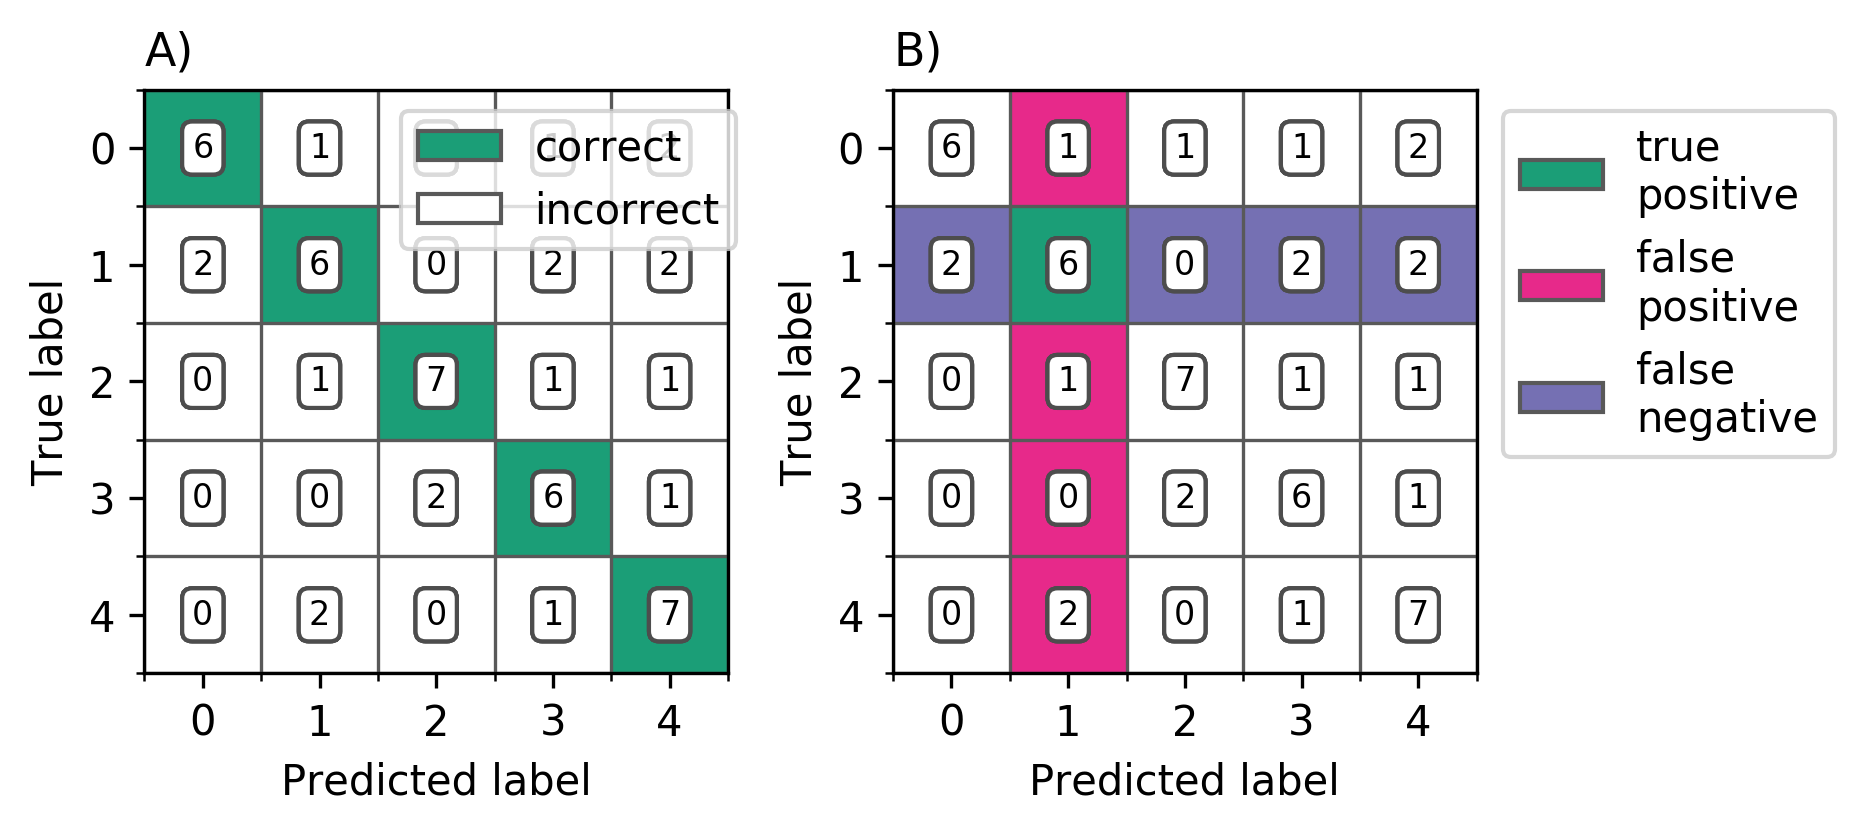

Classification scores:
$$ \text{accuracy} = \frac{\text{correct}}{\text{all}} = \frac{\text{trace}(CM)}{\text{sum}(CM)} $$


$$ \text{precision} = \frac{\text{true positive}}{\text{true positive + false positive}} = \frac{CM[i,i]}{\text{sum}(CM[:,i]} $$


$$ \text{recall} = \frac{\text{true positive}}{\text{true positive + false negative}} = \frac{CM[i,i]}{\text{sum}(CM[i,:]} $$

Note that accuracy is calculated globally while precision and recall are calculated individually for each class.

In [ ]:
# implementing the confusion matrix is not difficult but sklearn gives it to us in one line
cm_pca = confusion_matrix(y_gt_numeric, y_pred_pca)
print('pca clustering confusion matrix')
print(cm_pca)
cm_tsne = confusion_matrix(y_gt_numeric, y_pred_tsne)
print('tsne clustering confusion matrix')
print(cm_tsne)


Most elements are on the diagonal, but it's difficult to tell which class is which. 

Therefore, I give you a function to more clearly visualize the performance.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5), dpi=150)
vis.pretty_cm(cm_pca, ax0=ax[0])
vis.pretty_cm(cm_tsne, ax0=ax[1])
ax[0].set_title('clustering on pca')
ax[1].set_title('clustering on t-sne')


In both cases, clustering works very well for Cr and Rs (perfect recall, very high precision.) The performance for scratches and inclusions is much worse. clustering on pca data also has trouble with patches.

If we look at the pano image visualization, we can see that the confusion comes from clusters that are close to each other.

## classification scores
The scores are easy to compute from the confusion matrix. However, to make life even easier, sklearn gives us the classification_report() function.

In [ ]:
# to get the report in terms of string labels instead of integer labels, we
# need to tell the function what each integer label corresponds to
int_to_label = {y:x for x,y in label_map.items()}
target_names = [int_to_label[x] for x in range(6)]
print(target_names)

In [ ]:
print('Classification metrics from clustering PCA data')
print(classification_report(y_gt_numeric, y_pred_pca, target_names=target_names))

In [ ]:
print('Classification metrics from clustering T-SNE map')
print(classification_report(y_gt_numeric, y_pred_tsne, target_names=target_names))

# Can we do better?

Here's another approach all in one step (after loading the dataframe)

In [ ]:
#  select features
fc1 = np.stack(df['vgg16_fc1_feature'])

## PCA dimension reduction with whitening
pca_50 = PCA(n_components=50, # number of components we want to keep
             svd_solver='full', # for larger data matrices we can use 'randomized' (and set random_state if desired) which will run faster
             whiten=True) # will apply the whitening transformation after computing the components
X_pca_50 = pca_50.fit_transform(fc1)

## kmeans with 7 clusters directly on pca
kmeans7 = KMeans(n_clusters=7, n_init=200, random_state=1468)
kmeans7.fit(X_pca_50)

# align labels
label_map = ct.label_mapper
y_gt_numeric = [label_map[x] for x in df['label_x']] 
y_pred_km7 = ct.label_matcher(kmeans7.labels_, df['label_x'])

# confusion matrix visualization
cm = confusion_matrix(y_gt_numeric, y_pred_km7)
fig, ax = plt.subplots(figsize=(5,5))
vis.pretty_cm(cm, ax0=ax)

# classification report
int_to_label = {y:x for x,y in label_map.items()}
target_names = [int_to_label[x] for x in range(6)]

print('Classification metrics from new approach')
print(classification_report(y_gt_numeric, y_pred_km7, target_names=target_names))

96% accuracy, not bad!

# Summary
The approach we took is as follows:
  * load data
  * apply pca 
    * look at the fraction of variance to estimate an appropriate number of components
  * apply T-SNE to pca components to visualize structure of data
    * look at projections to see what they tell us about data
  * apply k-means to cluster both pca components and t-sne maps
  * interpret the results
    * visually by coloring t-sne
    * numerically with the confusion matrix and individual classification scores

# Additional things to try
  * Look at the documentation for pca, tsne, kmeans, etc to see other parameters to play with
  * Try different clustering methods. The process is pretty modular so you can switch out KMeans with something else and the rest of the process stays the same
  * Try clustering the different representations of the data (ie raw image pixels, histograms, etc)
  * Suggestion: for highest performance, compute fc1 features on images with histogram equalization to see